# LeNet Implementation!

1. Create a LeNet Model
2. Feed in the Augmented data
3. Finalize!

### Import the necessary packages

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string

import imghdr
from PIL import Image
from os import listdir


### Generate the LeNet Model!
**Requirements**
1. Input 32x32 image
2. Must adjust sizes if input is not 32x32

In [47]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()


        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 26)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv_layer(x)
        x = self.linear(x)
        return x

### Data handling

In [89]:
# Input: Path to a folder of .png files. Let #=dataset num, l = letter represented, v=variation, a=augmentation
#     Must be structured s.t. hand#_l_v_a.png
# Output: List of .png images and their respective labels
def loadImages(path):
    imagesList = listdir(path)
    imgs = []
    labels = []
    for image in imagesList: # iterate over all images in the folder
      if imghdr.what(path + image) == 'png':
        if (image[6].isalpha()): # 6th position is the letter
          img = Image.open(path + image)
          imgs.append(img)
          labels.append(ord(image[6]) - ord('a')) # assumes that filename structure is 'handx_[label]_....'
    return imgs, labels


# Process the data given input and output images. 
# Input: all required arguments
# Note: LeNet assumes input of 32. Resize is hyperparameter based on dataset.

# def process_data(imgs, labels, batch_size=4, channels=3, resize=15, crop_size=32, test_split=0.2):
#   transforms_array = applyTransforms(imgs, channels, crop_size, resize=resize)
#   train_data, test_data, train_labels, test_labels = train_test_split(transforms_array, labels, test_size=test_split, random_state=42)
#   [trainloader, testloader] = train_test_loaders(train_data, train_labels, test_data, test_labels, batch_size)
#   return [trainloader, testloader]


# Input: the images list (3 channels), crop size, and resize hyperparameters
# Output: a tensor array of all the reshaped + resized images
def applyTransforms(imgs, crop_size, resize):
  # Define the necessary preprocessing transforms
  num_imgs = len(imgs)
  preprocess = transforms.Compose([
    transforms.Resize(resize), # Hyperparameter
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  # Create tensor array
  transforms_array = np.zeros((num_imgs, 3, crop_size, crop_size))
  for i in range(num_imgs):
    temp = preprocess(imgs[i])
    transforms_array[i,:,:,:] = temp
  
  return transforms_array

# Input: an image tensor [num_imgs, channels, x_dim, y_dim], test split, and a batch size
# Output: a tensor array of all the reshaped + resized images
def train_dev_loaders(transforms_array, test_split=0.2, batch_size=4):
  ## Create the training dataand trainloader
  train_data, dev_data, train_labels, dev_labels = train_test_split(transforms_array, labels, test_size=test_split, random_state=42)
  train_data_and_labels = []
  for i in range(len(train_data)):
    sample = (torch.Tensor(train_data[i,:,:,:]), train_labels[i])
    train_data_and_labels.append(sample)

  trainloader = torch.utils.data.DataLoader(train_data_and_labels, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  ## Create the developmental data and devloader
  dev_data_and_labels = []
  for i in range(len(dev_data)):
    sample = (torch.Tensor(dev_data[i,:,:,:]), dev_labels[i])
    dev_data_and_labels.append(sample)

  devloader = torch.utils.data.DataLoader(dev_data_and_labels, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
  return [train_data, train_labels, trainloader, dev_data, dev_labels, devloader]

# Input: One normalized image
# Output: None
# Plots the image, assumed to be [3, x_dim, y_dim]
def imshow(img):
  # Unnormalize the image before showing!
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                        std = [ 1., 1., 1. ]),
                                  ])
    img = invTrans(img)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# Input: list of .png images, their labels, and other default parameters
# Output: None
# Plots the image, assumed to be [3, x_dim, y_dim]
def test_loader(transforms_array, labels, batch_size=4):
    ## Create the testing data and testloader    
    test_data_and_labels = []
    for i in range(len(transforms_array)):
      sample = (torch.Tensor(transforms_array[i,:,:,:]), labels[i])
      test_data_and_labels.append(sample)

    testloader = torch.utils.data.DataLoader(test_data_and_labels, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    return testloader



In [49]:
# Train the model parameters
def train_model(trainloader, criterion, optimizer, model, num_images, n=20):

  print_schedule = num_images // 5
  for epoch in range(n):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % print_schedule == (print_schedule-1):    # print every 200 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
              running_loss = 0.0

  print('Finished Training')
  return model

# Test the model on help out dev set
def test_model(testloader, model):
    correct = 0
    total = 0
    misclass_ind = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item() # Calculate number correct
            if ((predicted != labels).sum().item()) > 0:
                incorrect = predicted - labels
                for i in range(len(incorrect)):
                    if incorrect[i] != 0:
                        misclass_ind.append(total + i)           
                    
            total += labels.size(0) # for each batch (size=4), predict the labels


    print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

    return correct, total, misclass_ind

# Show number_batches * display_num images
def show_true_vs_predicted(testloader, classes, model, num_batches, batch_size):
    # print images
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_batches * batch_size)))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(num_batches * batch_size)))



# Model Training: Data without Augmentation

In [50]:
## Step 1: Declare the model and associated classes
classes = list(string.ascii_uppercase)
lenet_no_aug = LeNet(len(classes))
batch_size = 4
channels = 3
xdim = 32
ydim = 32

In [51]:
# Step 2: Create the trainloader and testloader instances
path = "./Data_full/"
imgs, labels = loadImages(path)
print(f"Total number of images in Dataset is: {len(imgs)}")

transforms_array = applyTransforms(imgs, crop_size=32, resize=15)
[train_data, train_labels, trainloader, dev_data, dev_labels, devloader] = train_dev_loaders(transforms_array, test_split=0.2, batch_size=batch_size)

Total number of images in Dataset is: 650


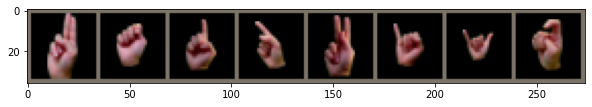

labels: U     T     D     Z     K     I     Y     X    


In [52]:
# Step 3: Visualize how some of the images look after processing the data
def visualize_images(trainloader, num_display, batch_size, xdim, ydim):
  dataiter = iter(trainloader)
  images = torch.empty((num_display * batch_size, channels, xdim, ydim))
  labels = torch.empty((num_display * batch_size), dtype=torch.uint8)
  #images, labels = dataiter.next()

  start_index = 0
  stop_index = batch_size
  for i in range(num_display):
    image, label = dataiter.next()
    images[start_index:stop_index,:,:,:] = image
    labels[start_index:stop_index] = label
    start_index = stop_index
    stop_index += batch_size

  imshow(torchvision.utils.make_grid(images))
  # print labels
  print("labels: " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_display * batch_size)))




visualize_images(trainloader, num_display=2, batch_size=batch_size, xdim=xdim, ydim=ydim)

In [53]:
# Step 4: Declare the loss function and optimizer for training
lr = 0.001  # Too large suboptimal convergence. Too small is process gets stuck. Find a balance
momentum = 0.9 # Standard should be close to 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_no_aug.parameters(), lr=lr, momentum=momentum)

In [55]:
train_model(trainloader, criterion, optimizer, lenet_no_aug, num_images=len(train_data), n=20);

[1,   104] loss: 16.958
[2,   104] loss: 16.894
[3,   104] loss: 16.795
[4,   104] loss: 16.461
[5,   104] loss: 14.013
[6,   104] loss: 8.036
[7,   104] loss: 4.246
[8,   104] loss: 2.327
[9,   104] loss: 1.735
[10,   104] loss: 1.439
[11,   104] loss: 0.927
[12,   104] loss: 0.833
[13,   104] loss: 0.639
[14,   104] loss: 0.238
[15,   104] loss: 0.198
[16,   104] loss: 0.127
[17,   104] loss: 0.095
[18,   104] loss: 0.046
[19,   104] loss: 0.139
[20,   104] loss: 0.079
Finished Training


In [56]:
print("Evalating on the held-out developmenta set...")
correct, total, misclass_ind = test_model(devloader, lenet_no_aug)

print(f"Correct: {correct} \nTotal: {total}")

Evalating on the held-out developmenta set...
Accuracy of the network on the 130 test images: 97 %
[95, 98, 111]
Correct: 127 
Total: 130


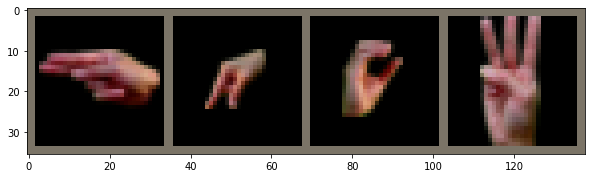

GroundTruth:  H     Q     C     W    
Predicted:  H     Q     C     W    


In [57]:
classes = list(string.ascii_uppercase)
show_true_vs_predicted(devloader, classes, lenet_no_aug, num_batches=1, batch_size=batch_size)

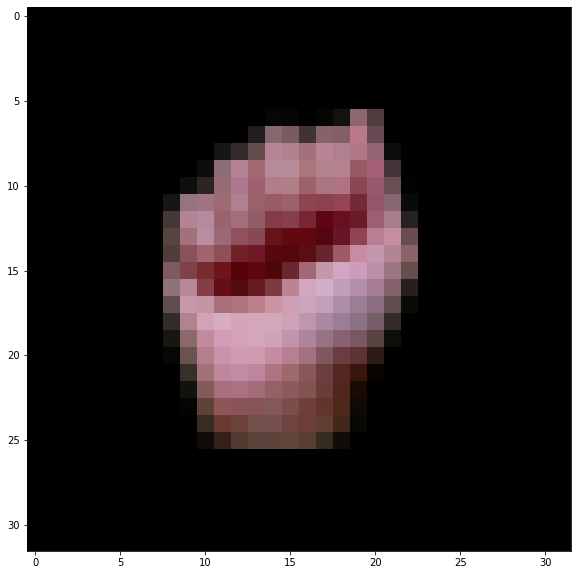

Actual labels: A    
predicted labels: S    


In [58]:
# Visualize some incorrect values:
def show_incorrect(misclass_ind, images, labels, model, num_display=1):
  if len(misclass_ind) != 0:
    incorrect_imgs = torch.Tensor([images[i] for i in misclass_ind])
    true_labels = [labels[i] for i in misclass_ind]

    outputs = model(incorrect_imgs)
    _, predicted = torch.max(outputs, 1)

    incorrect_imgs = incorrect_imgs[:num_display, :, :, :]
    true_labels = true_labels[:num_display]
    predicted = predicted[:num_display]


    imshow(torchvision.utils.make_grid(incorrect_imgs))
    print("Actual labels: " + ' '.join(f'{classes[true_labels[j]]:5s}' for j in range(num_display)))
    print("predicted labels: " + ' '.join(f'{classes[predicted[j]]:5s}' for j in range(num_display)))
    

show_incorrect(misclass_ind, dev_data, dev_labels, lenet_no_aug)


In [59]:
# Save the model!
torch.save(lenet_no_aug.state_dict(), "./models/lenet_no_aug_650")

## Part 2: Apply on Data Augmentation Set

In [60]:
## Step 1: Declare the model and associated classes
classes = list(string.ascii_uppercase)
lenet_with_aug = LeNet(len(classes))
batch_size = 4
channels = 3
xdim = 32
ydim = 32

In [61]:
# Step 2: Create the trainloader and testloader instances
path = "./FinalImages/"
imgs, labels = loadImages(path)
print(f"Total number of images in Dataset is: {len(imgs)}")

transforms_array = applyTransforms(imgs, crop_size=32, resize=35)
[train_data, train_labels, trainloader, dev_data, dev_labels, devloader] = train_dev_loaders(transforms_array, test_split=0.2, batch_size=batch_size)

Total number of images in Dataset is: 3900


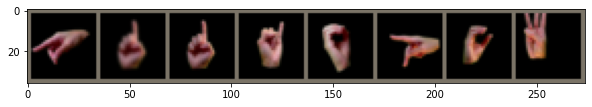

labels: P     D     D     I     O     P     C     W    


In [62]:
# Step 3: Visualize how some of the images look after processing the data
visualize_images(trainloader, num_display=2, batch_size=batch_size, xdim=xdim, ydim=ydim)

In [63]:
# Step 4: Declare the loss function and optimizer for training

lr = 0.001  # Too large suboptimal convergence. Too small is process gets stuck. Find a balance
momentum = 0.9 # Standard should be close to 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_with_aug.parameters(), lr=lr, momentum=momentum)

In [64]:
train_model(trainloader, criterion, optimizer, lenet_with_aug, num_images=len(train_data), n=20);

[1,   624] loss: 100.276
[2,   624] loss: 65.648
[3,   624] loss: 42.975
[4,   624] loss: 31.120
[5,   624] loss: 22.729
[6,   624] loss: 17.933
[7,   624] loss: 13.842
[8,   624] loss: 11.032
[9,   624] loss: 10.236
[10,   624] loss: 8.233
[11,   624] loss: 5.518
[12,   624] loss: 5.274
[13,   624] loss: 2.996
[14,   624] loss: 4.364
[15,   624] loss: 3.645
[16,   624] loss: 2.285
[17,   624] loss: 2.857
[18,   624] loss: 2.253
[19,   624] loss: 2.872
[20,   624] loss: 1.952
Finished Training


In [65]:
print("Evalating on the held-out developmental set...")
correct, total, misclass_ind = test_model(devloader, lenet_with_aug)

print(misclass_ind)

print(f"Correct: {correct} \nTotal: {total}")

Evalating on the held-out developmental set...
Accuracy of the network on the 780 test images: 87 %
[1, 10, 12, 13, 29, 31, 44, 51, 62, 64, 65, 80, 81, 83, 89, 112, 115, 121, 128, 134, 136, 140, 164, 174, 206, 218, 221, 223, 233, 236, 251, 253, 269, 271, 278, 328, 333, 339, 340, 346, 349, 352, 382, 384, 407, 412, 413, 420, 422, 427, 440, 445, 448, 465, 469, 477, 496, 497, 498, 499, 508, 512, 518, 523, 528, 540, 566, 580, 590, 596, 598, 607, 608, 614, 617, 639, 655, 665, 668, 676, 682, 687, 692, 695, 700, 701, 719, 721, 722, 742, 746, 747, 748, 761, 763, 764, 769, 772]
Correct: 682 
Total: 780


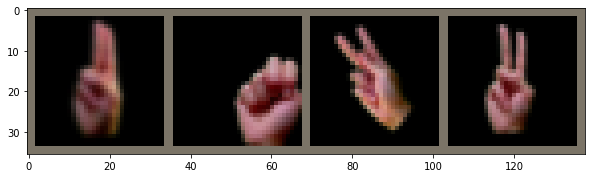

GroundTruth:  U     N     K     V    
Predicted:  U     T     K     V    


In [66]:
classes = list(string.ascii_uppercase)
show_true_vs_predicted(devloader, classes, lenet_with_aug, num_batches=1, batch_size=batch_size)

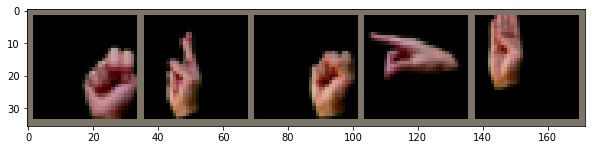

Actual labels: N     R     S     P     B    
predicted labels: T     F     T     H     E    


In [67]:
def show_incorrect(misclass_ind, images, labels, model, num_display=1):

  incorrect_imgs = torch.Tensor([images[i] for i in misclass_ind])
  true_labels = [labels[i] for i in misclass_ind]

  outputs = model(incorrect_imgs)
  _, predicted = torch.max(outputs, 1)

  incorrect_imgs = incorrect_imgs[:num_display, :, :, :]
  true_labels = true_labels[:num_display]
  predicted = predicted[:num_display]


  imshow(torchvision.utils.make_grid(incorrect_imgs))
  print("Actual labels: " + ' '.join(f'{classes[true_labels[j]]:5s}' for j in range(num_display)))
  print("predicted labels: " + ' '.join(f'{classes[predicted[j]]:5s}' for j in range(num_display)))
  
show_incorrect(misclass_ind, dev_data, dev_labels, lenet_with_aug, num_display=5)


In [68]:
import datetime

In [69]:
# Save the model!
time = datetime.datetime.now()
torch.save(lenet_with_aug.state_dict(), f"./models/lenet_with_aug_3900")

### Part 3: Compare each model (trained with vs without augmented data) on newly augmented data

In [70]:
path = './Mult_Augments/'

test_imgs, test_labels = loadImages(path)

#transforms_array_test_data = applyTransforms(test_imgs, crop_size=32, resize=35)
testloader = test_loader(test_imgs, test_labels, crop_size=32, resize=35)

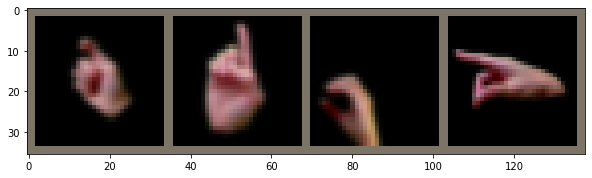

labels: X     D     C     P    


In [71]:
# Step 1: Visualize how some of the images look after processing the data
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [72]:
lenet_no_aug = LeNet(len(classes))
lenet_no_aug.load_state_dict(torch.load("./models/lenet_no_aug_650"))
lenet_no_aug.eval()

test_model(testloader, lenet_no_aug)

Accuracy of the network on the 650 test images: 32 %


(213,
 650,
 [1,
  2,
  3,
  4,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  14,
  17,
  18,
  20,
  21,
  22,
  25,
  28,
  31,
  32,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  42,
  43,
  44,
  47,
  48,
  49,
  50,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  64,
  65,
  67,
  68,
  69,
  71,
  72,
  73,
  75,
  76,
  77,
  79,
  80,
  81,
  82,
  83,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  96,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  107,
  108,
  110,
  111,
  112,
  114,
  115,
  116,
  120,
  121,
  124,
  125,
  126,
  128,
  129,
  132,
  133,
  134,
  135,
  138,
  139,
  140,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  151,
  152,
  153,
  155,
  157,
  158,
  161,
  162,
  163,
  165,
  167,
  168,
  169,
  170,
  171,
  172,
  175,
  179,
  180,
  182,
  183,
  184,
  186,
  187,
  189,
  190,
  191,
  194,
  195,
  196,
  198,
  199,
  200,
  201,
  202,
  203,
  205,
  206,
  207,
  208,
  210,
  211,
  214,
  217,
  218

In [73]:
lenet_with_aug = LeNet(len(classes))
lenet_with_aug.load_state_dict(torch.load("./models/lenet_with_aug_3900"))
lenet_with_aug.eval()

test_model(testloader, lenet_with_aug)

Accuracy of the network on the 650 test images: 69 %


(450,
 650,
 [1,
  10,
  14,
  15,
  18,
  24,
  25,
  27,
  31,
  36,
  39,
  40,
  42,
  43,
  45,
  46,
  47,
  48,
  61,
  63,
  66,
  68,
  69,
  71,
  84,
  89,
  91,
  92,
  95,
  103,
  107,
  109,
  113,
  114,
  118,
  119,
  120,
  122,
  125,
  134,
  137,
  141,
  148,
  151,
  154,
  155,
  157,
  158,
  159,
  163,
  164,
  167,
  169,
  170,
  172,
  175,
  177,
  186,
  187,
  189,
  199,
  200,
  203,
  204,
  206,
  209,
  210,
  212,
  215,
  216,
  221,
  228,
  231,
  232,
  233,
  237,
  238,
  240,
  244,
  248,
  251,
  259,
  262,
  268,
  271,
  277,
  283,
  291,
  299,
  300,
  301,
  302,
  303,
  306,
  308,
  310,
  315,
  316,
  318,
  321,
  324,
  327,
  328,
  333,
  336,
  337,
  340,
  347,
  351,
  352,
  354,
  355,
  356,
  362,
  364,
  369,
  374,
  378,
  383,
  384,
  385,
  386,
  391,
  399,
  402,
  404,
  407,
  409,
  411,
  419,
  421,
  424,
  425,
  431,
  441,
  442,
  443,
  446,
  448,
  451,
  456,
  459,
  460,
  461,
  468,
  4

### Trish Fish Second Folder

In [90]:
path = './Only_Mult_Augments/'

test_imgs, test_labels = loadImages(path)

transforms_array = applyTransforms(test_imgs, crop_size=32, resize=35)
testloader = test_loader(transforms_array, test_labels)

Accuracy of the network on the 650 test images: 15 %


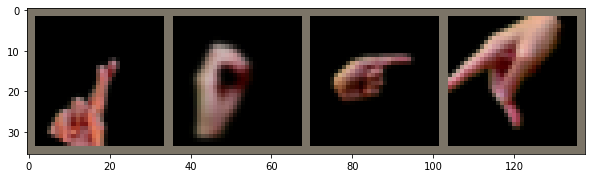

Actual labels: R     O     G     P    
predicted labels: Z     E     Q     O    


In [91]:
lenet_no_aug = LeNet(len(classes))
lenet_no_aug.load_state_dict(torch.load("./models/lenet_no_aug_650"))
lenet_no_aug.eval()

correct, total, misclass_ind = test_model(testloader, lenet_no_aug)
show_incorrect(misclass_ind, transforms_array, test_labels, lenet_no_aug, num_display=4)


Accuracy of the network on the 650 test images: 57 %


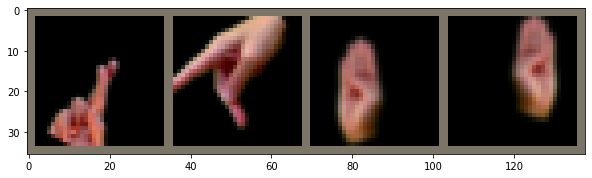

Actual labels: R     P     B     B    
predicted labels: N     Q     W     W    


In [92]:
lenet_with_aug = LeNet(len(classes))
lenet_with_aug.load_state_dict(torch.load("./models/lenet_with_aug_3900"))
lenet_with_aug.eval()

correct, total, misclass_ind = test_model(testloader, lenet_with_aug)
show_incorrect(misclass_ind, transforms_array, test_labels, lenet_with_aug, num_display=4)